In [1]:
!unzip -q "/content/drive/MyDrive/BAH-2025/bah_2025.zip"

In [2]:
# 📚 Step 3: Import dependencies
import os
import numpy as np
import tensorflow as tf
import tifffile as tiff
import matplotlib.pyplot as plt
from natsort import natsorted
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

In [3]:
# 🧠 Step 4: Utilities

def load_dataset_paths(lr_dir, hr_dir):
    lr_files = natsorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir) if f.endswith(".tif")])
    hr_files = natsorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir) if f.endswith(".tif")])
    paired_data = []
    for i in range(0, len(lr_files) - 1, 2):
        paired_data.append((lr_files[i], lr_files[i+1], hr_files[i // 2]))
    return paired_data

def load_sample_dual_inputs(lr1_path, lr2_path, hr_path):
    lr1 = tiff.imread(lr1_path).astype(np.float32) / 65535.0
    lr2 = tiff.imread(lr2_path).astype(np.float32) / 65535.0
    hr  = tiff.imread(hr_path).astype(np.float32) / 65535.0
    return (np.expand_dims(lr1, -1), np.expand_dims(lr2, -1)), np.expand_dims(hr, -1)

def split_dataset(lr_dir, hr_dir, test_size=0.2):
    all_pairs = load_dataset_paths(lr_dir, hr_dir)
    return train_test_split(all_pairs, test_size=test_size, random_state=42)

def tf_dataset_dual_input_from_pairs(paired_paths, batch_size=8):
    def generator():
        for lr1_path, lr2_path, hr_path in paired_paths:
            yield load_sample_dual_inputs(lr1_path, lr2_path, hr_path)

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            (tf.TensorSpec((256, 256, 1), tf.float32),
             tf.TensorSpec((256, 256, 1), tf.float32)),
            tf.TensorSpec((512, 512, 1), tf.float32)
        )
    ).shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [4]:
# 🎯 Step 5: PSNR + SSIM Metrics

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [ ]:
# 🏗️ Step 6: Build Model

def build_dual_input_srcnn():
    input1 = layers.Input(shape=(256, 256, 1), name="lr_input_1")
    input2 = layers.Input(shape=(256, 256, 1), name="lr_input_2")

    def feature_branch(x):
        x = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(x)
        x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
        return x

    feat1 = feature_branch(input1)
    feat2 = feature_branch(input2)

    x = layers.Concatenate()([feat1, feat2])
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    output = layers.Conv2D(1, (3, 3), padding='same', activation='linear')(x)

    return models.Model(inputs=[input1, input2], outputs=output)



In [5]:
# 📍 Step 7: Set paths
lr_dir = "/content/train_lr"
hr_dir = "/content/train_hr"

train_pairs, val_pairs = split_dataset(lr_dir, hr_dir)
train_ds = tf_dataset_dual_input_from_pairs(train_pairs, batch_size=8)
val_ds   = tf_dataset_dual_input_from_pairs(val_pairs, batch_size=8)

In [ ]:
# ⚙️ Step 8: Compile + Callbacks

model = build_dual_input_srcnn()
model.compile(optimizer='adam', loss='mse',
              metrics=[psnr_metric, ssim_metric, 'mae'])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='psnr_metric',
    patience=5,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/best_dual_input_model.h5",
    monitor='psnr_metric',
    save_best_only=True,
    mode='max'
)

In [ ]:
# 🚀 Step 9: Train the model and store history
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
)

# 💾 Final save
model.save("/content/drive/MyDrive/final_dual_input_model.h5")
print("✅ Training complete. Final model saved to Drive.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


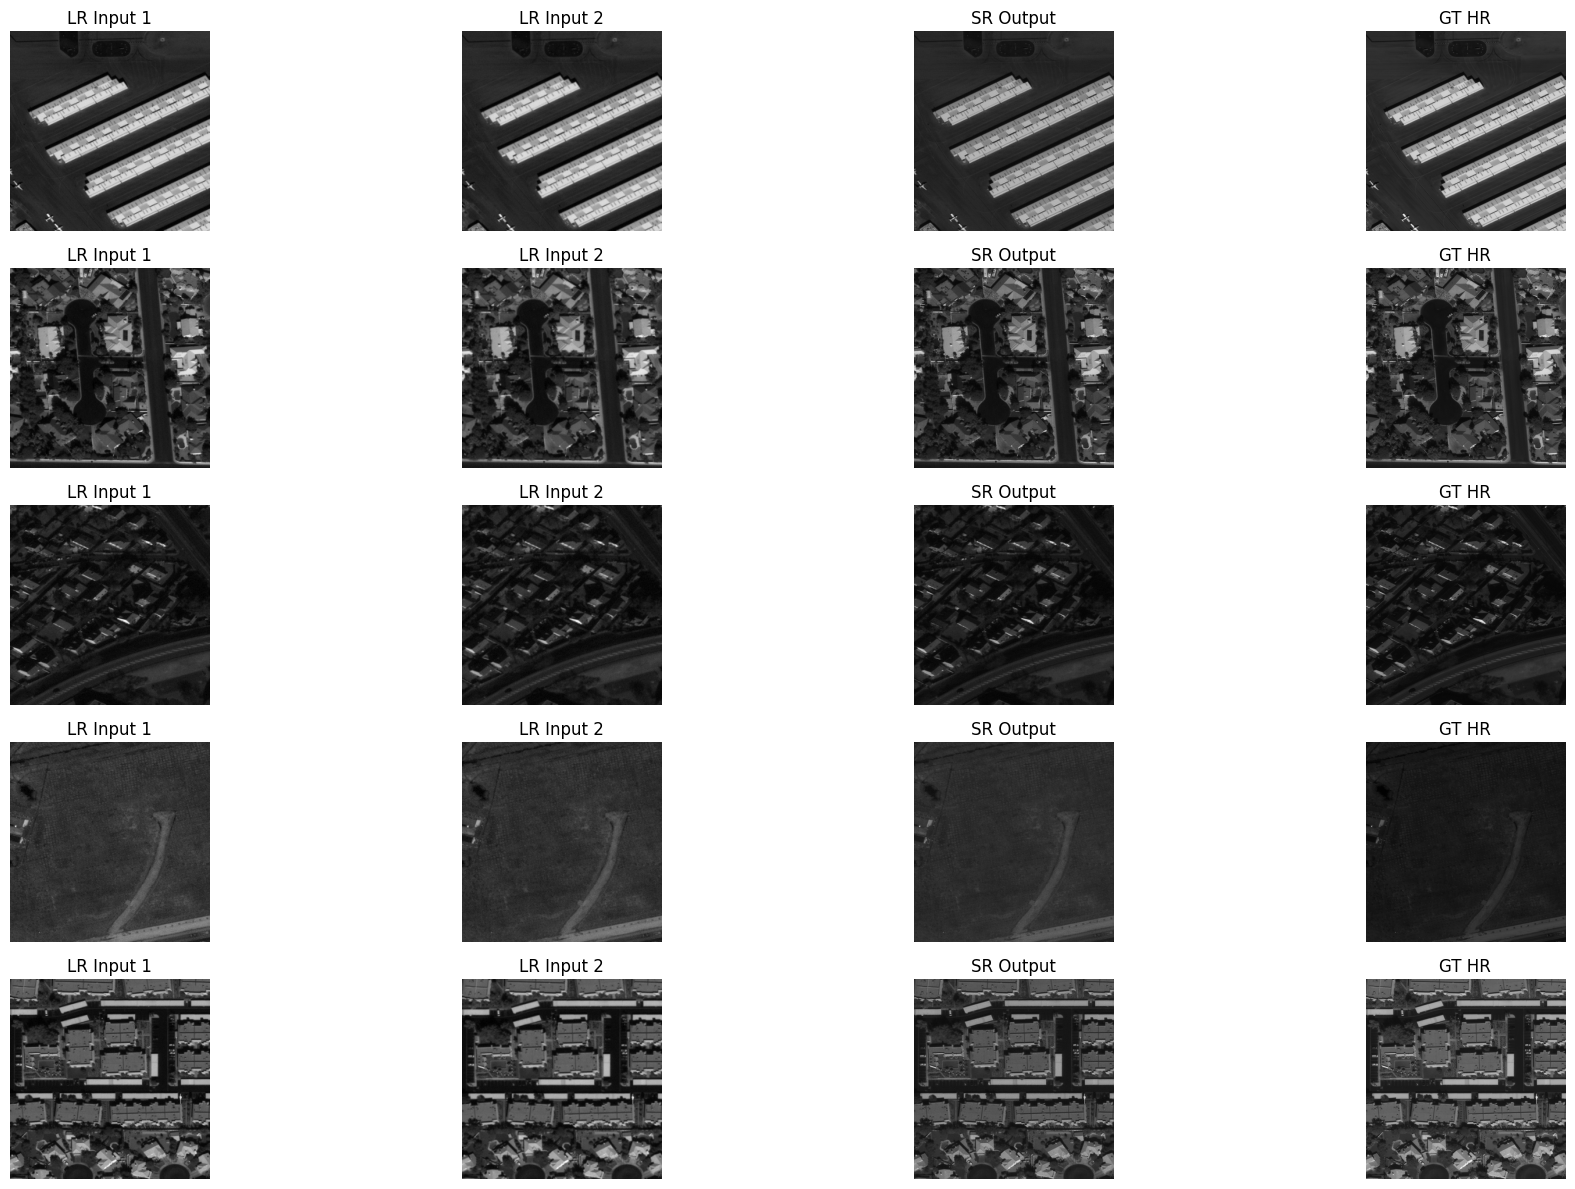

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import tensorflow as tf
from natsort import natsorted
import random

# 📁 Directories
lr_dir = "/content/train_lr"
hr_dir = "/content/train_hr"
model_path = "/content/drive/MyDrive/final_dual_input_model.h5"

# 🧠 Load model
model = tf.keras.models.load_model(
     model_path,
     custom_objects={"psnr_metric": psnr_metric, "ssim_metric": ssim_metric,"mse":tf.keras.losses.MeanSquaredError()}
)

# 🔄 Sort using natsort
lr_files = natsorted([f for f in os.listdir(lr_dir) if f.endswith(".tif")])
hr_files = natsorted([f for f in os.listdir(hr_dir) if f.endswith(".tif")])

# ✅ Form correct (lr1, lr2, hr) triplets
paired = []
for i in range(0, len(lr_files) - 1, 2):
    lr1_file = lr_files[i]
    lr2_file = lr_files[i + 1]
    hr_file = hr_files[i // 2]
    paired.append((lr1_file, lr2_file, hr_file))

# 🎯 Choose 5 random triplets
samples = random.sample(paired, 5)

# 📊 Display 5 rows: LR1, LR2, SR Output, GT HR
plt.figure(figsize=(20, 12))
for idx, (lr1_file, lr2_file, hr_file) in enumerate(samples):
    lr1 = tiff.imread(os.path.join(lr_dir, lr1_file)).astype(np.float32) / 65535.0
    lr2 = tiff.imread(os.path.join(lr_dir, lr2_file)).astype(np.float32) / 65535.0
    hr  = tiff.imread(os.path.join(hr_dir, hr_file)).astype(np.float32) / 65535.0

    # Predict SR
    input1 = np.expand_dims(lr1, axis=(0, -1))  # shape: (1, H, W, 1)
    input2 = np.expand_dims(lr2, axis=(0, -1))
    sr = model.predict([input1, input2])[0, ..., 0]

    # Plot
    plt.subplot(5, 4, idx * 4 + 1); plt.imshow(lr1, cmap='gray'); plt.title("LR Input 1"); plt.axis('off')
    plt.subplot(5, 4, idx * 4 + 2); plt.imshow(lr2, cmap='gray'); plt.title("LR Input 2"); plt.axis('off')
    plt.subplot(5, 4, idx * 4 + 3); plt.imshow(sr, cmap='gray'); plt.title("SR Output"); plt.axis('off')
    plt.subplot(5, 4, idx * 4 + 4); plt.imshow(hr, cmap='gray'); plt.title("GT HR"); plt.axis('off')

plt.tight_layout()
plt.show()



In [7]:
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))


In [8]:
!pip install pydot
!apt-get install graphviz  # For Colab


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


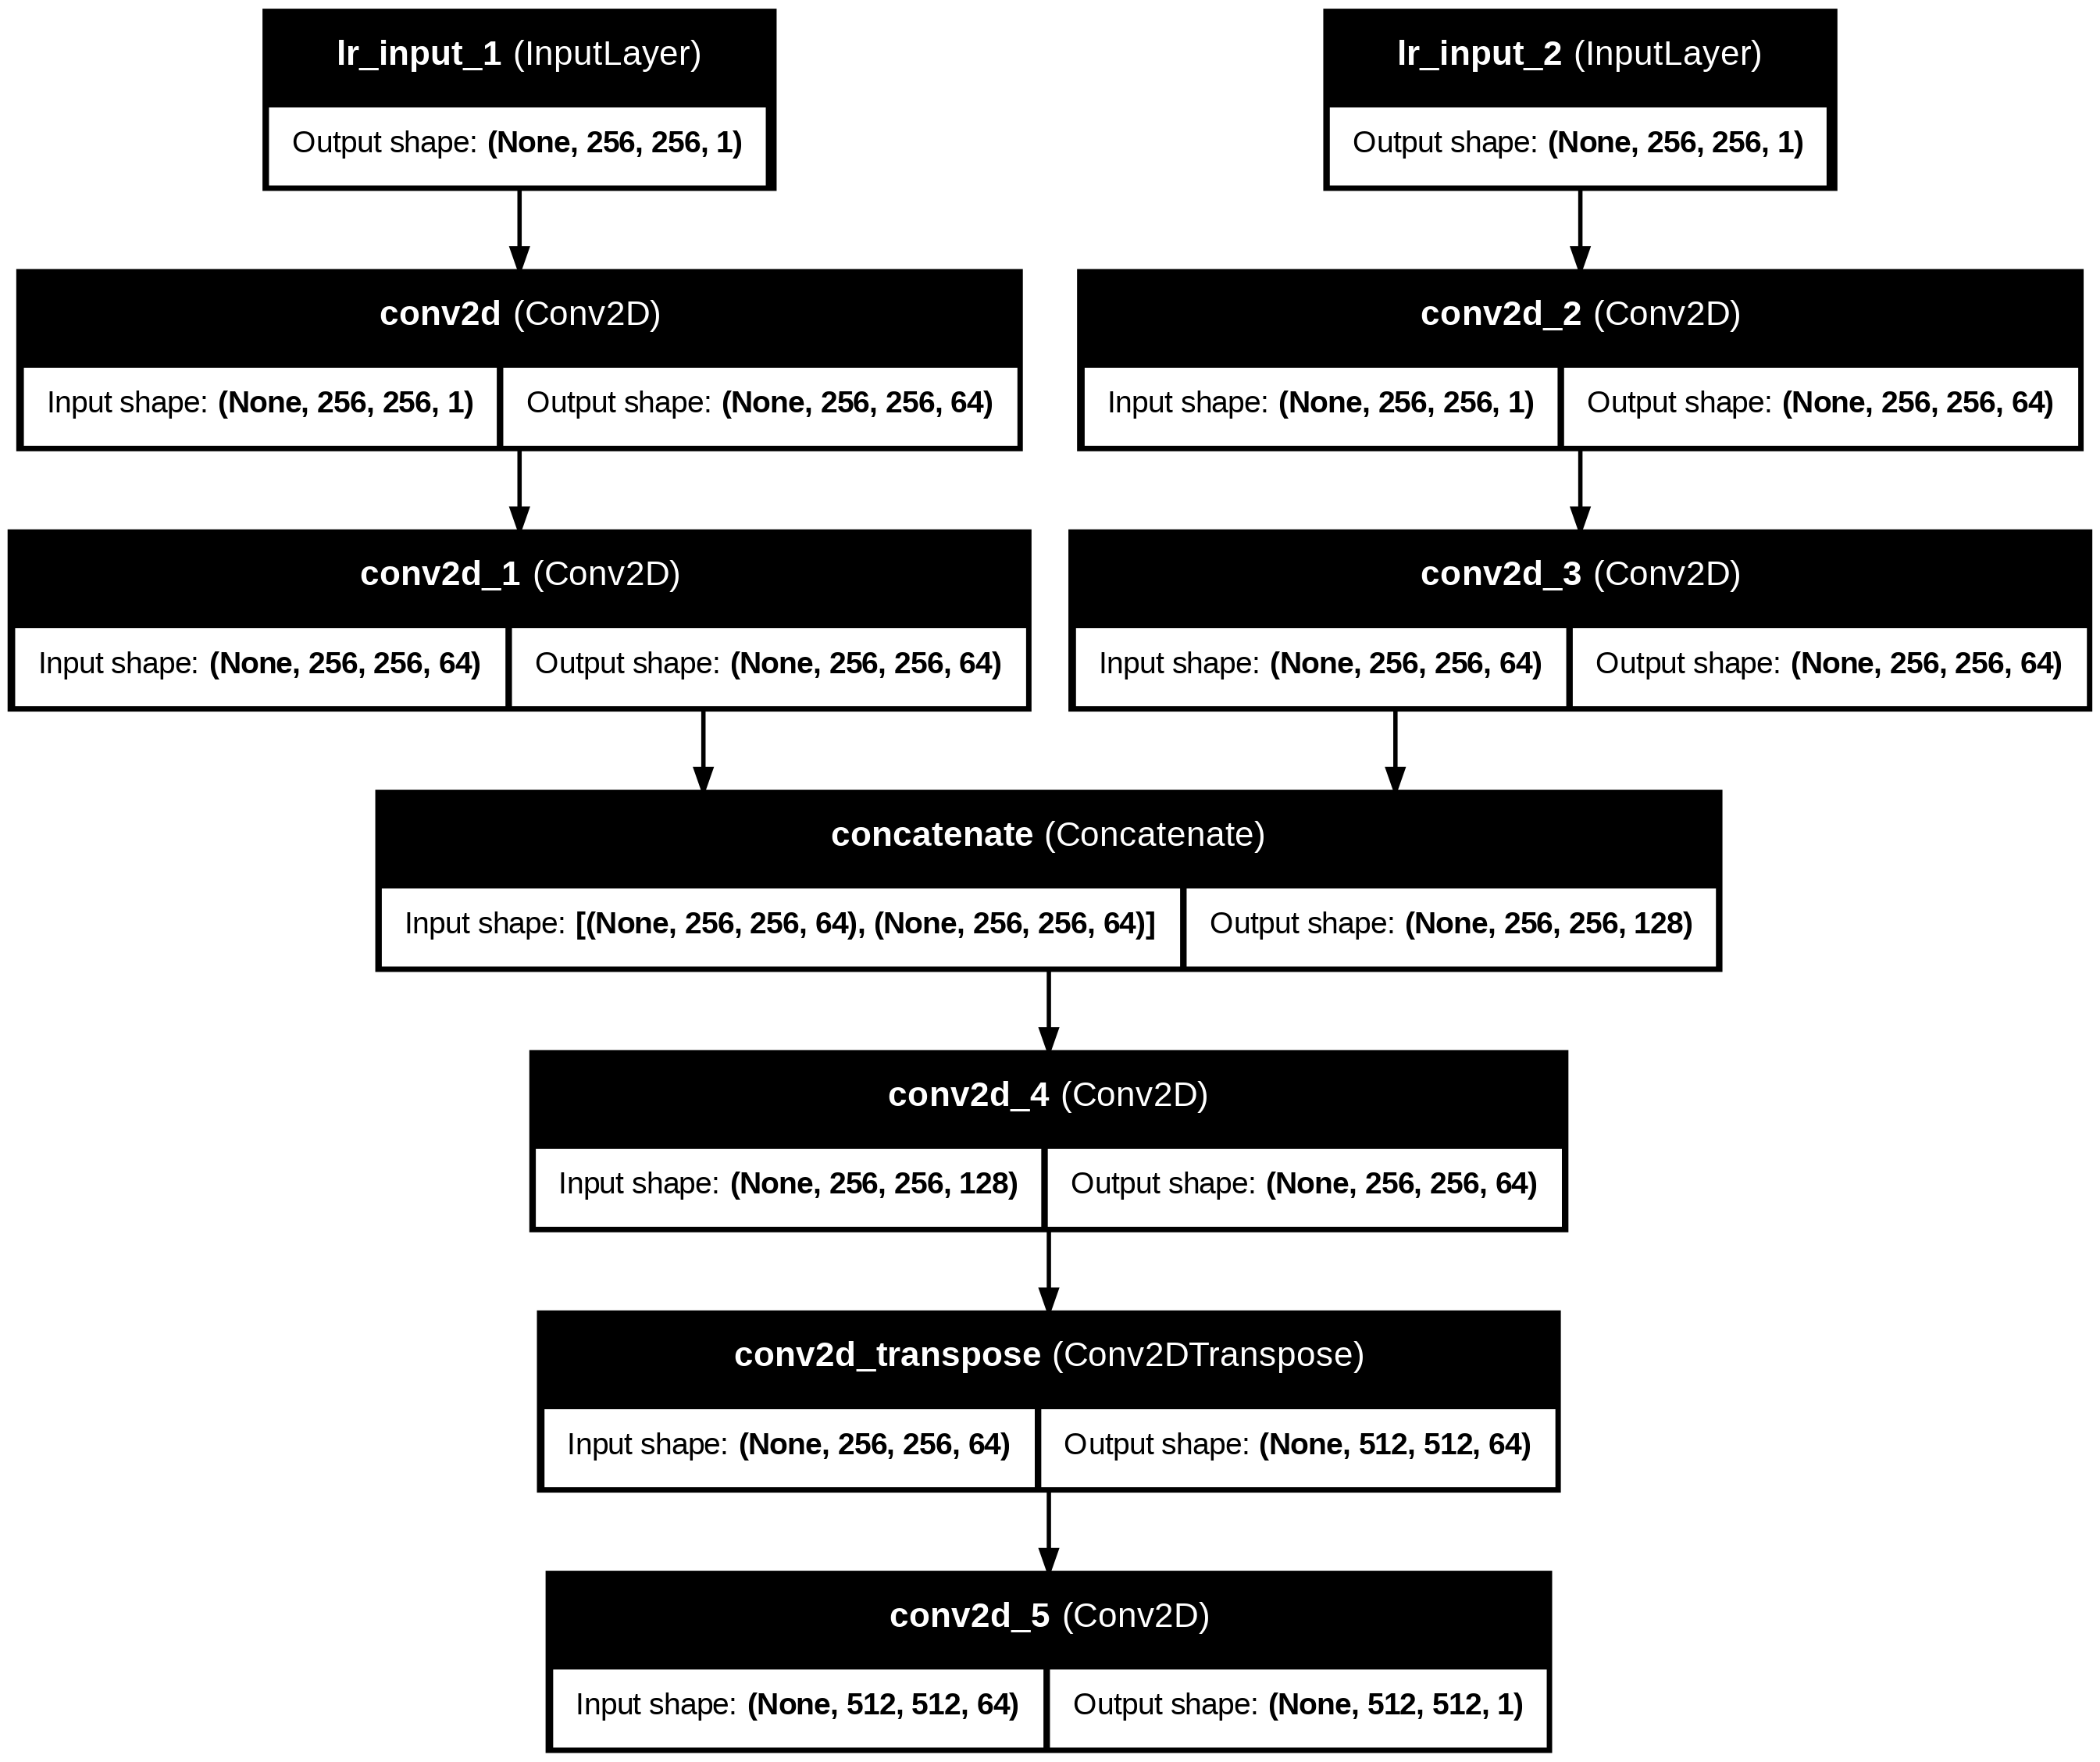

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [4]:
!pip uninstall -y opencv-python opencv-python-headless
!pip install opencv-contrib-python --upgrade


Found existing installation: opencv-python-headless 4.12.0.88
Uninstalling opencv-python-headless-4.12.0.88:
  Successfully uninstalled opencv-python-headless-4.12.0.88


In [3]:
!wget https://raw.githubusercontent.com/opencv/opencv_contrib/master/modules/quality/samples/brisque_model_live.yml
!wget https://raw.githubusercontent.com/opencv/opencv_contrib/master/modules/quality/samples/brisque_range_live.yml


--2025-07-08 07:47:24--  https://raw.githubusercontent.com/opencv/opencv_contrib/master/modules/quality/samples/brisque_model_live.yml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 567815 (555K) [text/plain]
Saving to: ‘brisque_model_live.yml.1’

brisque_model_live. 100%[===================>] 554.51K  --.-KB/s    in 0.05s   

2025-07-08 07:47:24 (11.5 MB/s) - ‘brisque_model_live.yml.1’ saved [567815/567815]

--2025-07-08 07:47:24--  https://raw.githubusercontent.com/opencv/opencv_contrib/master/modules/quality/samples/brisque_range_live.yml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

In [1]:
import os
print(os.path.exists("/content/brisque_model_live.yml"))  # should print True
print(os.path.exists("/content/brisque_range_live.yml"))  # should print True


True
True


In [6]:
import os
import numpy as np
import tensorflow as tf
import tifffile as tiff
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float32
import pandas as pd
import cv2
from natsort import natsorted

# 📁 Set Paths
lr_dir = "/content/train_lr"
hr_dir = "/content/train_hr"
out_dir = "/content/sr_output"
model_path = "/content/drive/MyDrive/final_dual_input_model.h5"
os.makedirs(out_dir, exist_ok=True)

# 📦 Load Model
model = tf.keras.models.load_model(
    model_path,
    custom_objects={"psnr_metric": tf.image.psnr, "ssim_metric": tf.image.ssim ,"mse":tf.keras.losses.MeanSquaredError()}
)

# 🔧 Preprocess Utilities
def normalize_img(img):
    return img.astype(np.float32) / 65535.0 if img.max() > 1 else img

def load_and_preprocess(lr1_path, lr2_path):
    lr1 = normalize_img(tiff.imread(lr1_path))
    lr2 = normalize_img(tiff.imread(lr2_path))
    lr1 = np.expand_dims(lr1, axis=(0, -1))
    lr2 = np.expand_dims(lr2, axis=(0, -1))
    return [lr1, lr2]

def compute_blind_metrics(img):
    # Ensure 3-channel 8-bit input
    img_uint8 = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    if img_uint8.ndim == 2:
        img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)

    # Create quality metric objects
    # niqe_obj = cv2.quality.QualityNIQE_create()
    brisque_obj = cv2.quality.QualityBRISQUE_create(
        "/content/brisque_model_live.yml",
        "/content/brisque_range_live.yml"
    )
    # piqe_obj = cv2.quality.QualityPIQE_create()

    # Compute metrics
    # niqe_val = niqe_obj.compute(img_uint8)[0][0]
    brisque_val = brisque_obj.compute(img_uint8)
    # piqe_val = piqe_obj.compute(img_uint8)

    return brisque_val

# 📑 Get LR-HR Pairs
lr_files = natsorted([f for f in os.listdir(lr_dir) if f.endswith(".tif")])
hr_files = natsorted([f for f in os.listdir(hr_dir) if f.endswith(".tif")])
paired = [(lr_files[i], lr_files[i+1], hr_files[i//2]) for i in range(0, len(lr_files)-1, 2)]

results = []

# 🚀 Inference + Metrics
for lr1_file, lr2_file, hr_file in tqdm(paired[:50], desc="Evaluating"):
    lr1_path = os.path.join(lr_dir, lr1_file)
    lr2_path = os.path.join(lr_dir, lr2_file)
    hr_path = os.path.join(hr_dir, hr_file)

    inputs = load_and_preprocess(lr1_path, lr2_path)
    sr = model.predict(inputs)[0, :, :, 0]
    sr = np.clip(sr, 0, 1)

    hr = normalize_img(tiff.imread(hr_path))

    # Save SR image
    out_path = os.path.join(out_dir, f"SR_{hr_file}")
    tiff.imwrite(out_path, (sr * 65535).astype(np.uint16))

    # Full-reference
    psnr_val = psnr(hr, sr, data_range=1.0)
    ssim_val = ssim(hr, sr, data_range=1.0)

    # Blind metrics
    brisque_val = compute_blind_metrics(sr)

    results.append({
        "Image": hr_file,
        "PSNR": psnr_val,
        "SSIM": ssim_val,
        # "NIQE": niqe_val,
        "BRISQUE": brisque_val,
        # "PIQE": piqe_val
    })

# 💾 Save Metrics
df = pd.DataFrame(results)
df.to_csv("/content/evaluation_metrics.csv", index=False)
print("✅ Metrics saved to evaluation_metrics.csv")


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating:   0%|          | 0/50 [00:02<?, ?it/s]


AttributeError: module 'cv2.quality' has no attribute 'QualityBRISQUE_create'

In [9]:
print("🔍 Columns in your CSV:")
print(df.columns)

🔍 Columns in your CSV:
Index(['Image', 'PSNR', 'SSIM', 'BRISQUE'], dtype='object')


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv("/content/evaluation_metrics.csv")

# Convert BRISQUE values to float if they are stored as list/tuple-like strings
def extract_float(val):
    if isinstance(val, str) and val.startswith('('):
        return float(val.split(',')[0].replace("(", ""))
    return float(val)

df["PSNR"] = df["PSNR"].astype(float)
df["SSIM"] = df["SSIM"].astype(float)
df["BRISQUE"] = df["BRISQUE"].apply(extract_float)



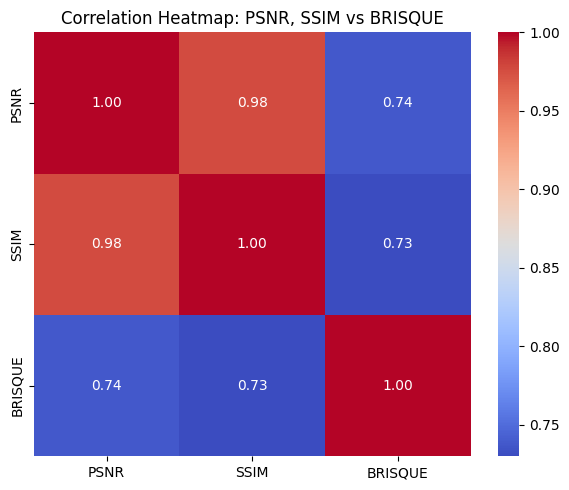

In [18]:
# Correlation Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(df[["PSNR", "SSIM", "BRISQUE"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: PSNR, SSIM vs BRISQUE")
plt.tight_layout()
plt.savefig("/content/correlation_heatmap.png", dpi=300)
plt.show()


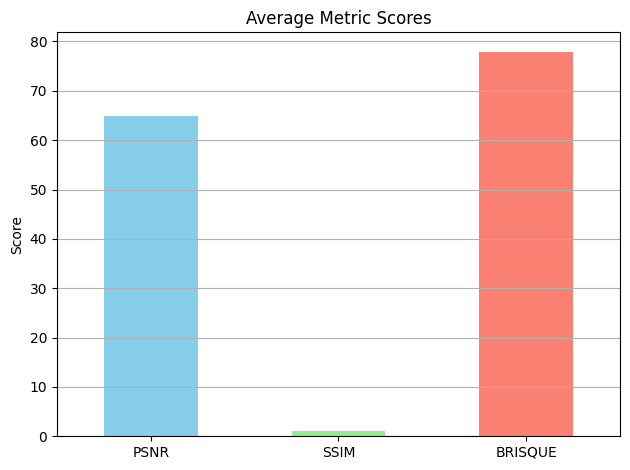

In [19]:
# Bar Chart of Average Scores
avg_scores = df[["PSNR", "SSIM", "BRISQUE"]].mean()

avg_scores.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Average Metric Scores")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("/content/average_metrics_scores.png", dpi=300)
plt.show()



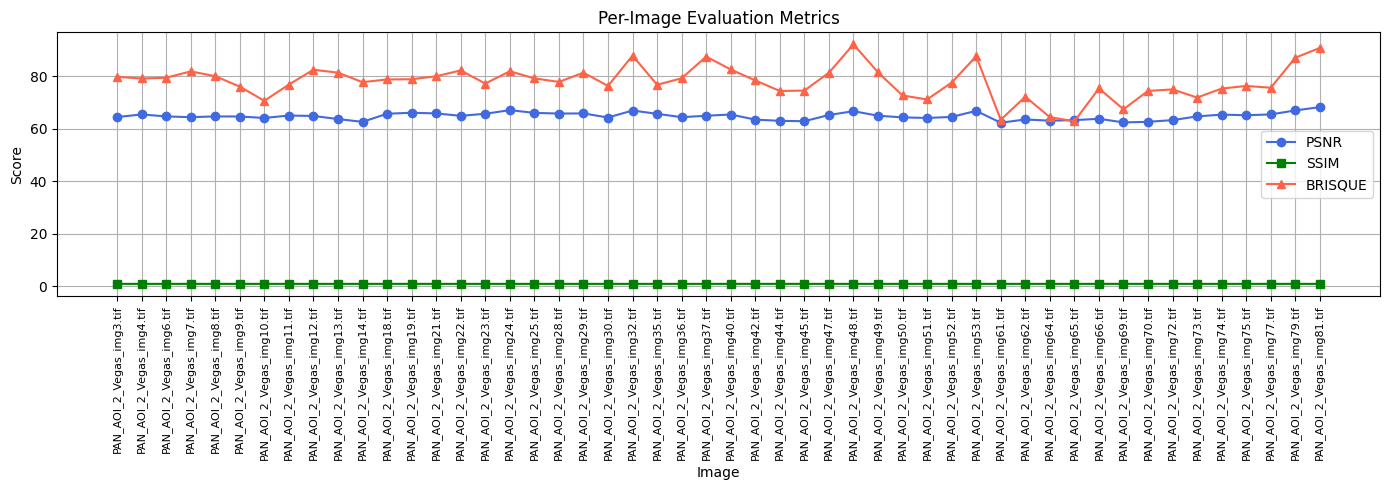

In [20]:
plt.figure(figsize=(14, 5))
plt.plot(df["Image"], df["PSNR"], marker='o', label="PSNR", color='royalblue')
plt.plot(df["Image"], df["SSIM"], marker='s', label="SSIM", color='green')
plt.plot(df["Image"], df["BRISQUE"], marker='^', label="BRISQUE", color='tomato')
plt.xticks(rotation=90, fontsize=8)
plt.title("Per-Image Evaluation Metrics")
plt.xlabel("Image")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/per-image_evaluation_metrics.png", dpi=300)
plt.show()



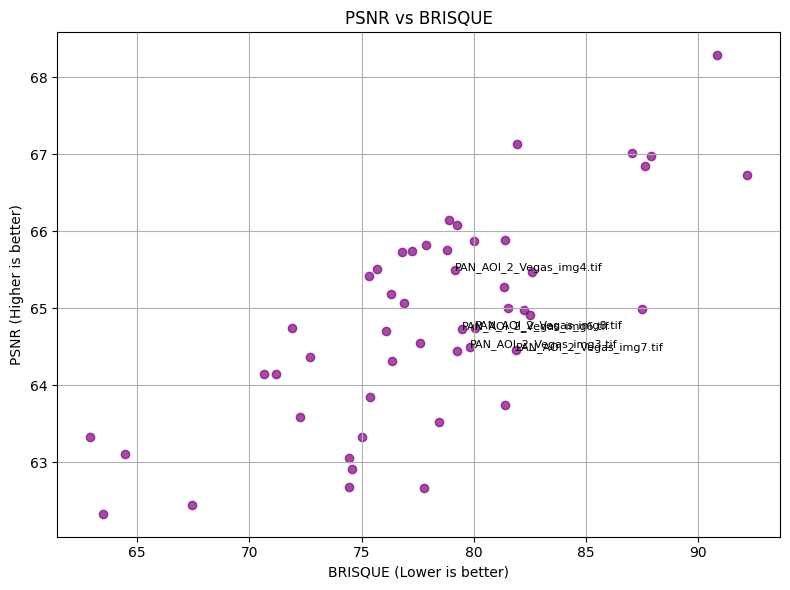

In [21]:
# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(df["BRISQUE"], df["PSNR"], color='purple', alpha=0.7)
plt.title("PSNR vs BRISQUE")
plt.xlabel("BRISQUE (Lower is better)")
plt.ylabel("PSNR (Higher is better)")
plt.grid(True)

# Optionally annotate few points
for i in range(min(5, len(df))):  # annotate first 5 points
    plt.annotate(df["Image"][i], (df["BRISQUE"][i], df["PSNR"][i]), fontsize=8)

plt.tight_layout()
plt.savefig("/content/psnr_vs_brisque.png", dpi=300)
plt.show()